In [1]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt
!pip install wandb -q
!pip install opencv-python -q

In [9]:
# Restart the runtime by ending the process
exit()

In [1]:
import os
import matplotlib.pyplot as plt


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS, MAP_NAN, NORMALIZE, LABELS_PATH, HEADER_PATH, SELECTED_BANDS
from serving.common import list_blobs_with_prefix
from serving.hist_training import (get_labels,
                                   #LstmModel,
                                   #TimeDependentDenseLstmModel,
                                   pen_low_lenient_high_loss,
                                   pen_low_loss,
                                   load_dataset_from_gcp,
                                   save_dataset_to_gcp,
                                   create_hist_dataset,
                                   train_wandb,
                                   train_model_data,
                                   plot_training_progress)
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels, check_blob_exists
import logging
import io
import itertools
import time

from keras.layers import LSTM, Dense, Dropout, Input, Normalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import wandb
from google.cloud import secretmanager

tf.config.run_functions_eagerly(True)

In [2]:
# Models
import keras
from keras.layers import LSTM, Dense, Dropout, Input, TimeDistributed, BatchNormalization
from tensorflow.keras.regularizers import l2
from serving.data import get_labels
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import randomname
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
import tempfile
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

class GradientDebugCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.batch_gradients = []

    def on_batch_begin(self, batch, logs=None):
        self.batch_gradients = []

    def on_batch_end(self, batch, logs=None):
        if batch % 100 == 0:  # Monitor every 10 batches
            # Get a batch of data
            for x_batch, y_batch in train_dataset.take(1):
                with tf.GradientTape() as tape:
                    # Forward pass
                    y_pred = self.model(x_batch, training=True)
                    # Compute loss
                    loss = self.model.compute_loss(y_batch, y_pred)

                # Get gradients
                gradients = tape.gradient(loss, self.model.trainable_variables)
                # grad_norms = [tf.norm(g).numpy() if g is not None else 0 for g in gradients]
                for i, (var, grad) in enumerate(zip(self.model.trainable_variables, gradients)):
                    if grad is not None:
                        print(f"\nLayer: {var.name}")
                        print(f"Parameter shape: {var.shape}")
                        print(f"Gradient norm: {tf.norm(grad).numpy()}")
                        print(f"Is trainable: {var.trainable}")


# Define the LSTM model
class LstmModel(keras.Model):
    def __init__(
        self,
        input_shape,
        lstm_layers=3,
        no_units=3,
        output_units=1,
        dropout_rate=0.2,
        val_size=10,
        kernel_initializer=tf.keras.initializers.RandomNormal()
    ):
        super(LstmModel, self).__init__()
        self.lstm_layers = lstm_layers
        self.no_units = no_units
        self.output_units = output_units
        self.dropout_rate = dropout_rate
        self.val_size = val_size

        self.input_layer = Input(shape=input_shape)
        self.batch_norm = BatchNormalization()
        
        # Define LSTM and Dense layers
        self.lstm_layers_list = []
        for i in range(lstm_layers):
            self.lstm_layers_list.append(
                LSTM(
                    units=no_units,
                    return_sequences=(i < lstm_layers - 1),
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal',
                    activation='tanh'
                )
            )
            
            if i < lstm_layers - 1:
                self.lstm_layers_list.append(Dropout(rate=dropout_rate))
        
        self.dense = Dense(
            units=output_units,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
            bias_initializer=tf.keras.initializers.Constant(100.0)
        )
        
        self.job_name = randomname.get_name(adj=('emotions',), noun=('food'))
    
    def get_config(self):
        return {
           "lstm_layers": self.lstm_layers,
           "no_units": self.no_units,
           "val_size": self.val_size,
           "ouput_units": self.output_units,
           "dropout_rate": self.dropout_rate,
           "kernel_initializer": self.kernel_initializer
        }
    
    @classmethod
    def from_config(cls, config):
        # Convert the serialized initializer back to a TF initializer
        config['kernel_initializer'] = tf.keras.initializers.deserialize(
            config['kernel_initializer']
        )
        return cls(**config)
    
    @tf.function
    def call(self, inputs, training=False):
        # LSTM layers

        x = inputs
        #x = self.batch_norm(x, training=training)

        for lstm_layer in self.lstm_layers_list:
            x = lstm_layer(x)

        outputs = self.dense(x)

        return outputs

    def summary(self):
        super(LstmModel, self).summary()

    def compile(
        self, optimizer="adam", loss="mse", metrics=["mae"], learning_rate=0.001, **kwargs
    ):
        self.learning_rate = learning_rate

        # Dictionary to map optimizer names to their classes
        optimizers = {"adam": Adam, "nadam": Nadam, "rms": RMSprop}

        # Get the optimizer class from the dictionary
        optimizer_class = optimizers.get(optimizer.lower(), Adam)

        # Instantiate the optimizer with the specified learning rate
        optimizer_instance = optimizer_class(learning_rate=learning_rate, clipnorm=1.0)

        # Compile the model with the chosen optimizer, loss, and metrics
        tf.config.run_functions_eagerly(True)
        
        if loss != "mse" and "mse" not in metrics:
            metrics.append("mse")
        
        super(LstmModel, self).compile(
            optimizer=optimizer_instance, loss=loss, metrics=metrics, **kwargs
        )
        
    

    def fit(self, dataset, epochs=10):

        # Shuffle and batch the dataset
        # dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

        # Split the dataset
        val_size = self.val_size
        val_dataset = dataset.take(val_size)
        train_dataset = dataset.skip(val_size)

        # Setup tensorboard
        model_name = f"{NUM_BINS}_buckets_{len(HIST_BINS_LIST)}" + '-' + self.job_name + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir = "gs://vgnn/tensorboard-artifacts/logs/fit/" + model_name
        if not os.path.exists(os.path.dirname(log_dir)):
            os.makedirs(os.path.dirname(log_dir))
            
        
        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        )

        
        # Train the model
        history = super(LstmModel, self).fit(
            train_dataset,
            epochs=epochs,
            # batch_size=batch_size,
            validation_data=val_dataset,
            callbacks=[early_stopping, WandbMetricsLogger()] #, GradientDebugCallback()
        )
        
        responses_train = np.concatenate(
            [response.numpy() for _, response in train_dataset], axis=0
        )
        mean_response_train = np.mean(responses_train)

        responses_val = np.concatenate(
            [response.numpy() for _, response in val_dataset], axis=0
            )        

        if val_size == 0:
            self.naive_loss = np.nan
        else:
            self.naive_loss = pen_low_lenient_high_loss(responses_val, mean_response_train)        
        
        # Plot training progress
        plot_training_progress(history, self.naive_loss)

        # Evaluate the model
        loss = self.evaluate(val_dataset)

        self.save(f'gs://vgnn/models/{model_name}.h5')

        return history


class TimeDependentDenseLstmModel(LstmModel):
    def __init__(
        self,
        input_shape,
        lstm_layers=3,
        no_units=3,
        dense_layers_per_step=3,
        output_units=1,
        dropout_rate=0.2,
        val_size=10,
        kernel_initializer=tf.keras.initializers.RandomNormal()
    ):
        super(TimeDependentDenseLstmModel, self).__init__(
            input_shape,
            lstm_layers,
            no_units,
            output_units,
            dropout_rate,
            val_size,
            kernel_initializer
        )
        
        self.lstm_layers = lstm_layers
        self.dense_layers_per_step = dense_layers_per_step
        self.no_units = no_units
        self.val_size = val_size
        self.dropout_rate = dropout_rate
        self.kernel_initializer = kernel_initializer
        
        # Dense layer to process each time step using TimeDistributed
        self.time_distributed_dense = []
        # Create the dense layers that will be applied to each time step
        units = input_shape[-1] // 2
        for _ in range(dense_layers_per_step):
            self.time_distributed_dense.append(
                TimeDistributed(Dense(units=units, 
                                      activation="relu",
                                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
                                      bias_initializer='ones', bias_regularizer=l2(0.01) ))
            )
            # units //= 2  # Halve units for each subsequent dense layer

    def get_config(self):
        config = super(TimeDependentDenseLstmModel, self).get_config()
        config.update({
            'dense_layers_per_step': self.dense_layers_per_step,
        })
        return config
    
    @tf.function
    def call(self, inputs, training=False):
        # Process each time step with a corresponding dense layer

        x = inputs
        # x = self.batch_norm(x, training=training)
        for dense_layer in self.time_distributed_dense:
            x = dense_layer(x)
        
        # Feed into LSTM layers
        for lstm_layer in self.lstm_layers_list:
            x = lstm_layer(x)

        outputs = self.dense(x)  # Final dense layer for output
        return outputs

In [3]:
# SETUP

# Create the Secret Manager client
client = secretmanager.SecretManagerServiceClient()

# Define the secret name and version
secret_name = "projects/1038596154733/secrets/wandb/versions/1"

# Access the secret
response = client.access_secret_version(name=secret_name)
secret_value = response.payload.data.decode('UTF-8')

#####
CREATE_DATASET = False
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
months = MONTHS
map_nan = MAP_NAN
normalize = NORMALIZE
num_bins = NUM_BINS
client = storage.Client()
bucket = client.get_bucket(bucket_name)


batch_size = 32
img_range =  {"count_start":0,
              "no_records":2500,
             "ascending": False}

In [4]:
map_nan = True
num_buckets_list = [60]
num_bands_list = [9]
infer_missing = True

if infer_missing:
    CREATE_DATASET = True
    for num_bins, num_bands in zip(num_buckets_list, num_bands_list):
        directory = f"dataset/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}"
        print(f"directory: {directory}")
        file_name =  "dataset_fips.tfrecords" # "hist_dataset_medium" # 



        # Generate all prefixes
        start_time = time.perf_counter()

        labels_df = get_varied_labels(**img_range)
        labels = list(zip(labels_df["county_name"],
                          labels_df["county_ansi"],
                     labels_df["state_ansi"],
                     labels_df["year"]))


        prefixes_hist = [f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                    for county,_, fips, year in labels]

        # Batch check all prefixes
        results_hist = batch_check_blobs(bucket_name, prefixes_hist)

        # Generate get_input_img_params based on results
        get_input_img_params = [(county.capitalize(), fips, year)
                    for county, county_fips, fips, year in labels
                    if results_hist[f'histograms/nan_map_{map_nan}/norm_{normalize}/{num_bins}_buckets_{num_bands}_bands/{SCALE}/{county.capitalize()}_{fips}/{year}']
        ]

        print(f"Number of items to process: {len(get_input_img_params)}")

        end_time_dataset_info = time.perf_counter()
        print(f"Collecting dataset information: {end_time_dataset_info-start_time}")
    
if CREATE_DATASET:
    dataset, dataset_shape, hist_npy, labels_npy = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins, num_bands=num_bands, fips=True)
    end_time_dataset = time.perf_counter()

    print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")

    # Save dataset
    save_dataset_to_gcp(hist_npy, labels_npy, directory=directory)
    print("Dataset created")
    print(directory,file_name,sep="/")
    CREATE_DATASET = False
else:

    dataset, dataset_shape = load_dataset_from_gcp(directory=directory)
    print("Dataset loaded")

input_shape = dataset_shape[1:]

directory: dataset/nan_map_True/norm_True/60_buckets_9_bands/60
Number of items to process: 9590
Reshaped histograms shape: (9578, 3, 541)
Labels shape: (9578, 1)
Number of filtered combinations: 12
Number of missing histograms replaced by zeros: 85
Building dataset: 7.2e+01 minutes
Labels uploaded to GCS successfully!
Dataset uploaded to GCS successfully!
Dataset saved to gs://vgnn/dataset/nan_map_True/norm_True/60_buckets_9_bands/60
Dataset created
dataset/nan_map_True/norm_True/60_buckets_9_bands/60/dataset_fips.tfrecords


In [20]:
np.save("all_images.npy", np.array(get_input_img_params))

In [ ]:
sum(results_hist.values())

In [4]:
# Sample labels
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Williams'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
1122,CORN,YEAR,2016,39,OHIO,171,WILLIAMS,169.1,USDA_Corn_County_2016.csv
2619,CORN,YEAR,2017,39,OHIO,171,WILLIAMS,167.3,USDA_Corn_County_2017.csv
3994,CORN,YEAR,2018,39,OHIO,171,WILLIAMS,182.0,USDA_Corn_County_2018.csv
5275,CORN,YEAR,2019,39,OHIO,171,WILLIAMS,156.3,USDA_Corn_County_2019.csv
6845,CORN,YEAR,2020,39,OHIO,171,WILLIAMS,143.9,USDA_Corn_County_2020.csv
8274,CORN,YEAR,2021,38,NORTH DAKOTA,105,WILLIAMS,58.0,USDA_Corn_County_2021.csv
8350,CORN,YEAR,2021,39,OHIO,171,WILLIAMS,189.5,USDA_Corn_County_2021.csv
9884,CORN,YEAR,2022,39,OHIO,171,WILLIAMS,187.9,USDA_Corn_County_2022.csv


In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)

#take subset
batch_size = 32

# Train test split
test_train_split = 0.8
train_size = int(dataset_shape[0] * test_train_split / batch_size)
val_size = int(train_size * (1-test_train_split))

batched_dataset = dataset.batch(batch_size, drop_remainder=True)

test_dataset = batched_dataset.skip(train_size)
train_dataset = batched_dataset.take(train_size)

# Adapt normalizer on unbatched training data
normalizer.adapt(train_dataset.map(lambda x, y: x))


# 3. Apply normalization to both datasets
train_dataset = train_dataset.map(lambda x, y: (normalizer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalizer(x), y))

# # Then batch the datasets
# test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
# train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

train_dataset = train_dataset.shuffle(buffer_size=10000)
print(f"Train size: {train_size} \nValidation size: {val_size}")
print("Data sets have been setup")

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Train size: 239 
Validation size: 47
Data sets have been setup


In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print("Input stats:")
    print("Mean:", tf.reduce_mean(inputs))
    print("Std:", tf.math.reduce_std(inputs))
    print("Min:", tf.reduce_min(inputs))
    print("Max:", tf.reduce_max(inputs))
    
    print("\nTarget stats:")
    print("Mean:", tf.reduce_mean(targets))
    print("Std:", tf.math.reduce_std(targets))

In [ ]:
# directory = "dataset/nan_map_False/norm_True/60_buckets_9_bands/60"
# model_name = "32_buckets_9-kind-croissant-20241029-045508.tf"

# epochs = 20
# train_model_data(model_name, directory)

In [32]:
for x, y in train_dataset.take(1):
    feature = x[0].numpy()

Initial predictions: [[100.01392]
 [100.01842]
 [100.01041]
 [100.01047]
 [100.0027 ]]
Initial predictions std: 0.014060558
Target values: [[132.2]
 [ 75.4]
 [112.3]
 [149. ]
 [137.2]]
Model compiled
Epoch 1/65
138/138 [==============================] - 22s 160ms/step - loss: 3697.2283 - mae: 48.7063 - mse: 3273.6582 - val_loss: 3371.9771 - val_mae: 46.5416 - val_mse: 3010.0833
Epoch 2/65
138/138 [==============================] - 22s 158ms/step - loss: 3362.5103 - mae: 44.1672 - mse: 2732.2986 - val_loss: 2842.5686 - val_mae: 41.3310 - val_mse: 2398.0723
Epoch 3/65
138/138 [==============================] - 22s 161ms/step - loss: 3015.1282 - mae: 41.0484 - mse: 2384.8247 - val_loss: 2804.3337 - val_mae: 38.4527 - val_mse: 2077.7341
Epoch 4/65
138/138 [==============================] - 22s 157ms/step - loss: 2992.5212 - mae: 38.6081 - mse: 2118.7971 - val_loss: 2678.8745 - val_mae: 38.5727 - val_mse: 2061.7949
Epoch 5/65
138/138 [==============================] - 23s 163ms/step - loss:

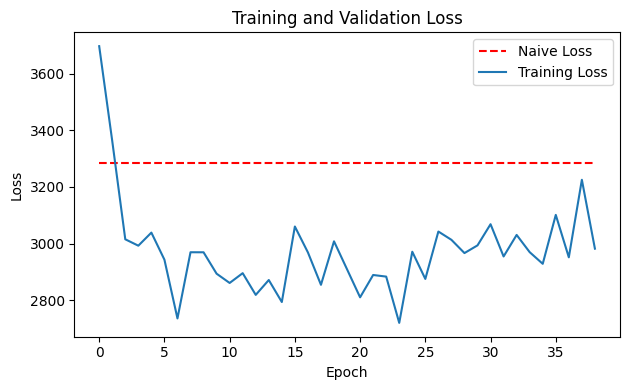

34/34 [==============================] - 1s 41ms/step - loss: 2792.8269 - mae: 33.4259 - mse: 1588.5294


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [15]:
wandb.init(
        # set the wandb project where this run will be logged
        project="blue-marble")

model = TimeDependentDenseLstmModel(input_shape = input_shape,
                                lstm_layers = 3,
                                dense_layers_per_step = 5,
                                no_units = 150,
                                val_size = val_size,
                                dropout_rate = 0.3,
                                kernel_initializer = tf.keras.initializers.RandomUniform(seed=42))
model.compile(optimizer= "nadam",
              learning_rate = 0.0006,
              loss=pen_low_loss)

for x, y in train_dataset.take(1):
    initial_pred = model(x)
    print("Initial predictions:", initial_pred.numpy()[:5])
    print("Initial predictions std:", np.std(initial_pred))
    print("Target values:", y.numpy()[:5])

print("Model compiled")

history = model.fit(train_dataset, epochs=65)
wandb.finish() 

In [8]:
secret_value

'6a41c5a7d5d063e33b4bea24275d0b3d7afd3865'

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


True

In [ ]:

# Define the initializers you want to test
initializers = [
    tf.keras.initializers.RandomNormal(seed=42),
    tf.keras.initializers.RandomUniform(seed=42),
    tf.keras.initializers.HeNormal(seed=42),
    tf.keras.initializers.GlorotUniform(seed=42)
]

sweep_configuration = {
    "name": "bm_sweep",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "validation_loss"},
    "count": 200,
    "parameters": {
        "lstm_layers_units": {"values": [(0,0), (3,5), (10,25)]},
        "dense_layers_per_step": {"values": [10, 17, 27]},
        "dropout_rate": {"values": [0.1, 0.2, 0.3]},
        "kernel_initializer": {"values": [0,1,2,3]},
        "num_bins_num_bands": {"values": [(12, 3), (12,9), (32,9), (60,3), (60,9)]},
        "lr": {"distribution": "uniform",
               "min": 0.0001,
               "max": 0.1},
        "batch_size": {"values": [16, 32, 64]},
        "epochs": {"values": [20]},
        "optimizer": {"values": ["adam", "rms", "nadam"]},
    },
}

sweep_id = wandb.sweep(sweep_configuration,
                      project="blue-marble")
wandb.agent(sweep_id, function=train_wandb)



In [12]:
wandb.finish()

epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▃▂▂▃▃▁▂
epoch/mae,█▅▄▃▂▂▂▁▂▁▁▁▁▁▁
epoch/mse,█▅▃▂▂▂▁▁▂▁▁▁▁▁▁
epoch/val_loss,█▆▄▂▃▂▅▃▄▅▁▁▅▃▆
epoch/val_mae,█▆▃▃▄▃▂▂▂▂▁▂▂▁▂
epoch/val_mse,█▆▃▂▃▂▂▂▂▁▁▂▁▁▂
epoch/epoch,14
epoch/learning_rate,0.001
epoch/loss,2916.63965


In [19]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 99ms/step - loss: 19518.5488 - mae: 131.6927 - mse: 20154.2793


[19518.548828125, 131.6927490234375, 20154.279296875]

In [22]:
print(model.job_name)

tf.Tensor(4171.9155, shape=(), dtype=float32)
lively-foie-gras


In [ ]:
for layer in model.layers:
    # Get weights for the layer
    weights = layer.get_weights()
    
    # Check if the layer has weights
    if weights:
        print(f"Layer: {layer.name}")
        for i, weight in enumerate(weights):
            print(f"  Weight {i+1} shape: {weight.shape}")
            print(f"  Weight {i+1} values: \n{weight}\n")
    else:
        print(f"Layer: {layer.name} has no weights.")

In [13]:
predictions = model.predict(test_dataset)

44/44 [==============================] - 2s 33ms/step


In [14]:
predictions

array([[144.70483],
       [144.70483],
       [144.70483],
       ...,
       [144.70483],
       [144.70483],
       [144.70483]], dtype=float32)

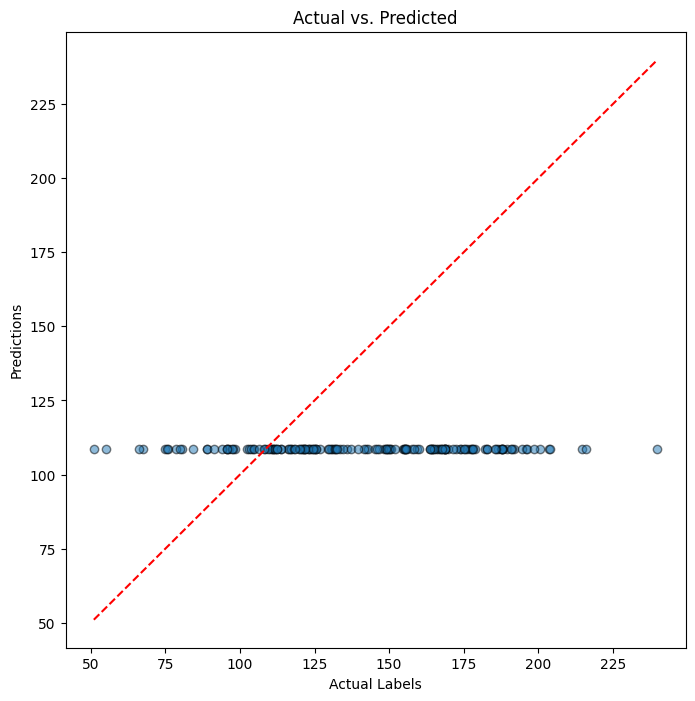

In [13]:
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [ ]:
for layer in model.layers:
    print(layer.weights)

In [44]:
import pandas as pd
import numpy as np
labels = pd.DataFrame(np.load(r'C:\Users\tskor\Documents\GitHub\inovation_project\2_Data\combined_labels_with_fips.npy', allow_pickle=True))


In [45]:
labels.head()

,0,1,2
0,01003,2016,152.9
1,01005,2016,188.9
2,01019,2016,92.3
3,01029,2016,125.0
4,01031,2016,104.5


In [61]:
histograms_path = r'C:\Users\tskor\Documents\data\histograms\histograms_county_year\histogram-31035-2016.npy'
histograms = pd.DataFrame(np.load(histograms_path, allow_pickle=True))
histograms.shape

(3, 543)

In [62]:
histograms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 543 entries, histogram_0 to fips
dtypes: int16(1), object(1), uint32(541)
memory usage: 6.5+ KB


In [34]:
hist_by_month_path = r"C:\Users\tskor\Documents\data\histograms\60_buckets_9_bands_60_res\60\Clay_31\2016\9-10.npy"
hist_month = np.load(hist_by_month_path)
print(hist_month)

[     0      0    115    214    245   3709  59917  88621  50741  24253
  14168  10653   7955   6512   5309   3159   1313    570    495    291
    119     52     46     55     27     29     28     23     23     22
     32     15     12      8      8      6      7     10      8      5
      2      4      1      6      1      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0    157    728  77664 114372
  28812  10135   9975   8209   6858   7077   5823   4308   2264   1071
    709    159     76     35     31     43     32     35     20     20
     21     18     17     11     16     15      7     11      5     10
      6      8      6      6      8      6      2      0      1      1
      0      0      0      0      0      0      0      0      1      0
      0      0      0      2     35    110    112    129    109    175
   1558   9499  34668  54828  47578  30861  19882  12675   8717   6402
   571

In [ ]:
5151001.0

In [43]:
for i in range(2016,2022):
    print(i)

2016
2017
2018
2019
2020
2021


In [59]:
weather_combined = pd.read_csv(r"C:\Users\tskor\Documents\data\WRF-HRRR\split_by_county_and_year\weather-combined.csv", dtype={'FIPS Code': str}).to_numpy()
weather_combined[:2,]

array([['talladega', '01121', 305.617, 278.059, 295.753,
        26709.16000000001, 0.994, 47.25, 0.0, 79.9710570944037, 4.182,
        8546.6, 136.5, 5185.8, 0.563, 5, 2017],
       ['geneva', '01061', 306.214, 280.606, 297.361, 4920.546000000001,
        0.656, 44.099, 0.0, 78.63302107728333, 8.859, 8579.0, 65.8,
        4786.0, 0.652, 5, 2017]], dtype=object)

In [ ]:
sat_data = np.load(r"C:\Users\tskor\Documents\data\histograms\histograms_county_year\histograms-combined.npy", allow_pickle=True)
sat_data[0,:]

(28734,)